In [354]:
import math
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)

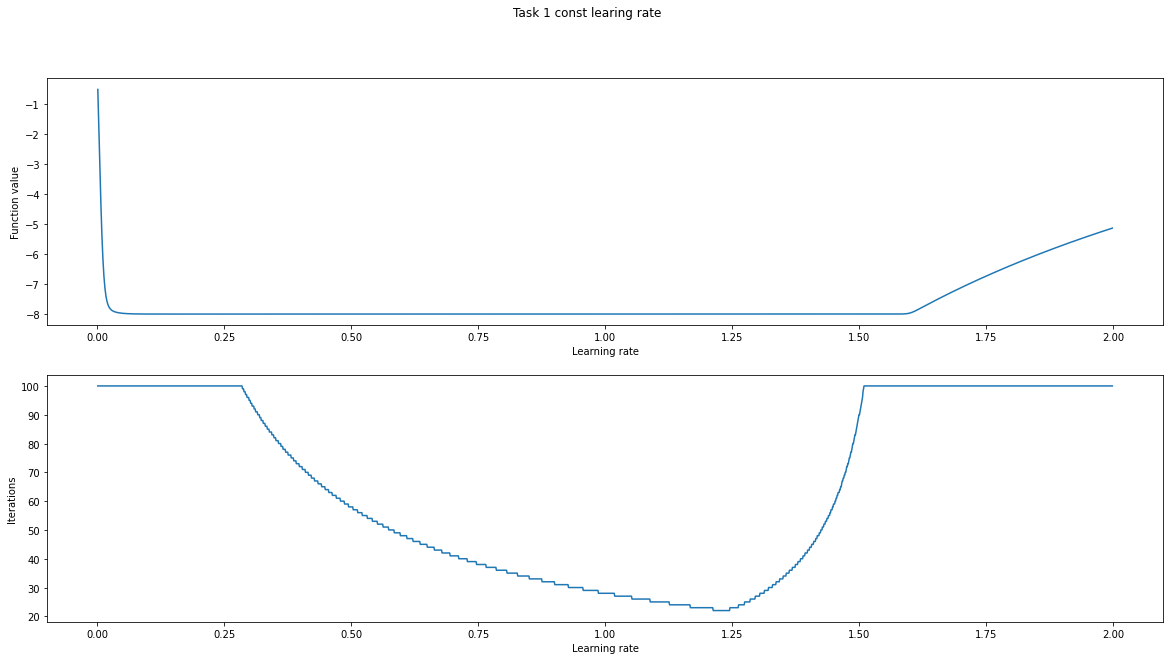

In [355]:
def grad_descent(derivative_func, step_func, start_point, iterations, eps):
    current_point = start_point
    for it in range(iterations):
        cur_der = derivative_func(current_point)
        step = step_func(it, cur_der, current_point)
        next_point = current_point - step * cur_der

        if np.linalg.norm(current_point-next_point) < eps:  # if dist < eps
            return current_point, it

        current_point -= step * cur_der

    return current_point, iterations

def const_learning_rate(value):
    return lambda i, _0, _1: value

func = lambda xs: 5 * math.sin(xs[0] / 2) - 3 * math.cos(xs[1] / 3)  # 5sin(x/2)-3cos(y/3)
derivative = lambda xs: np.array([5 / 2 * math.cos(xs[0] / 2), math.sin(xs[1] / 3)])  # [5/2 * cos(x/2), sin(y/3)]

lrs = np.arange(0.001, 2, 0.001)
func_vals = []
its = []

for lr in lrs:
    (xs, it) = grad_descent(
        derivative_func=derivative, 
        step_func=const_learning_rate(lr),
        start_point=np.array([1.0, 2.0]), 
        iterations=100,
        eps=1e-5
    )
    func_vals.append(func(xs))
    its.append(it)


fig, axs = plt.subplots(2)
fig.suptitle('Task 1 const learing rate')

axs[0].set_xlabel("Learning rate")
axs[0].set_ylabel("Function value")
axs[0].plot(lrs, func_vals)

axs[1].set_xlabel("Learning rate")
axs[1].set_ylabel("Iterations")
axs[1].plot(lrs, its)

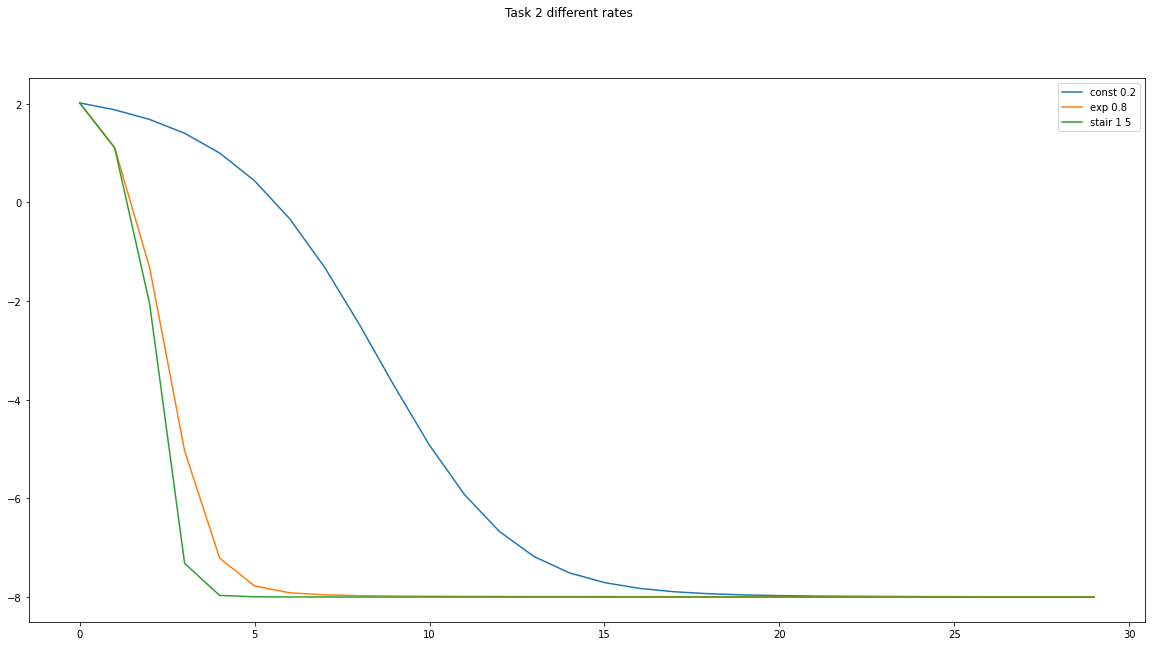

In [356]:
def exp_learning_rate(value):
    return lambda i, _0, _1: value ** i

def stair_learning_rate(coeff, size):
    return lambda i, _0, _1: coeff / (1 + i // size)

func = lambda xs: 5 * math.sin(xs[0] / 2) - 3 * math.cos(xs[1] / 3)  # 5sin(x/2)-3cos(y/3)
derivative = lambda xs: np.array([5 / 2 * math.cos(xs[0] / 2), math.sin(xs[1] / 3)])  # [5/2 * cos(x/2), sin(y/3)]

start_point = [-10.0, 20.0]

its = np.arange(30)

plots = []
for rate in [(const_learning_rate(0.2), "const 0.2"),
             (exp_learning_rate(0.8), "exp 0.8"),
             (stair_learning_rate(1, 5), "stair 1 5")]:
    plots.append(
      plt.plot(
          its,
          np.array(list(map(
              lambda it: func(grad_descent(derivative, rate[0], np.copy(start_point), it, 1e-5)[0]),
              its
          ))),
          label=rate[1]
      )[0]
    )

plt.suptitle('Task 2 different rates')
plt.legend(handles = plots)

In [357]:
def golden_section_search(func, l, r, eps):
    phi = (1 + math.sqrt(5)) / 2
    current_l = l
    current_r = r
    while current_r - current_l > eps:
        diff = current_r - current_l
        candidate_l = current_r - diff / phi
        candidate_r = current_l + diff / phi
        if func(candidate_l) > func(candidate_r):
            current_l = candidate_l
        else:
            current_r = candidate_r
    return (current_l + current_r) / 2


func = lambda x: (x + 5) ** 4  # (x+5)^4

l = -100
r = 100
eps = 0.2

x = golden_section_search(func, l, r, eps)

print(x)
func(x)

-5.02499874064149


3.9054629604039195e-07

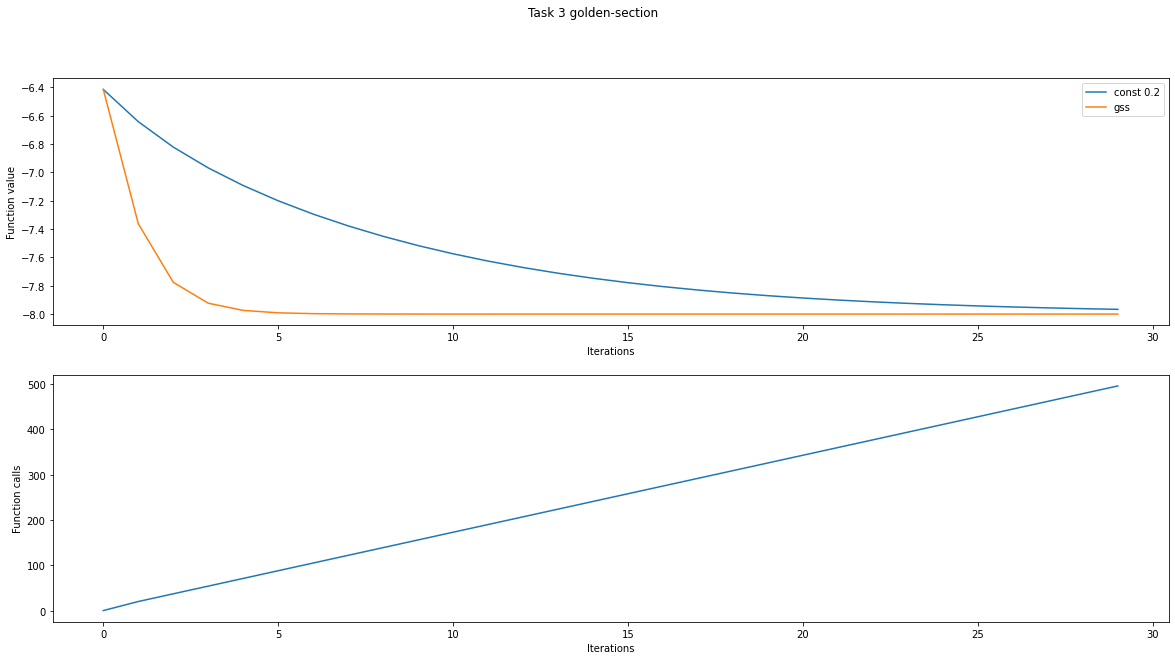

In [358]:
def create_gss_step_func(func):
    def step_func(it, cur_der, cur_point):
        def point_value(x):
            return func(cur_point - x * cur_der)
        alpha = 1.0
        l_v = point_value(0)
        prev_v = point_value(alpha)
        if l_v > prev_v:
            for i in range(10):
                alpha *= 2
                cur_v = point_value(alpha)
                if cur_v > prev_v:
                    break
                prev_v = cur_v
        return golden_section_search(point_value, 0.0, alpha, 0.1)
    return step_func

func = lambda xs: 5 * math.sin(xs[0] / 2) - 3 * math.cos(xs[1] / 3)  # 5sin(x/2)-3cos(y/3)
derivative = lambda xs: np.array([5 / 2 * math.cos(xs[0] / 2), math.sin(xs[1] / 3)])  # [5/2 * cos(x/2), sin(y/3)]

start_point = np.array([10.0, -3.0])

its = np.arange(30)

fig, axs = plt.subplots(2)
plots = []
for rate in [(const_learning_rate(0.2), "const 0.2"),
             (create_gss_step_func(func), "gss")]:
    plots.append(
      axs[0].plot(
          its,
          np.array(list(map(
              lambda it: func(grad_descent(derivative, rate[0], np.copy(start_point), it, 1e-5)[0]),
              its
          ))),
          label=rate[1]
      )[0]
    )

def count_func_calls(it):
    def counting_calls_func(xs):
        global number_of_calls
        counting_calls_func.number_of_calls += 1
        return func(xs)
    counting_calls_func.number_of_calls = 0
    grad_descent(derivative, create_gss_step_func(counting_calls_func), np.copy(start_point), it, 1e-15)[0]
    return counting_calls_func.number_of_calls

fig.suptitle('Task 3 golden-section')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Function value')
axs[0].legend(handles = plots)

axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('Function calls')
axs[1].plot(its, list(map(count_func_calls, its)))

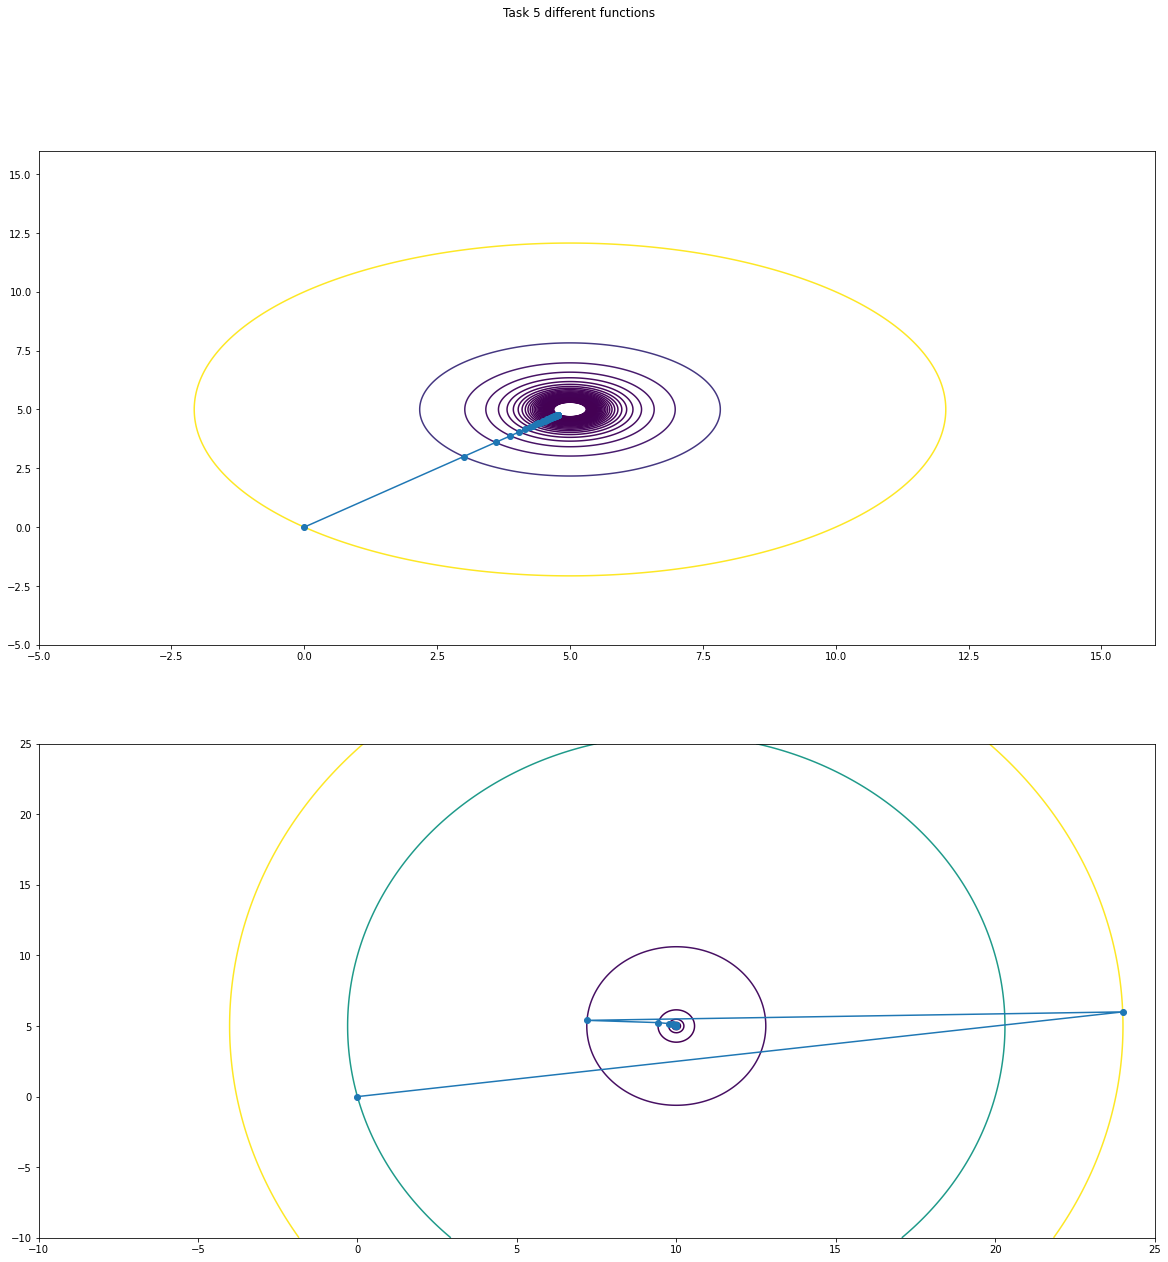

In [451]:
fig, axs = plt.subplots(2)

def draw(func, derivative, ax, l, r):
    t = np.linspace(l, r, 1000)
    X, Y = np.meshgrid(t, t)
    
    its = np.arange(50)
    points = list(map(lambda it: grad_descent(derivative, stair_learning_rate(0.3, 1), [0, 0], it, 1e-5)[0], its))
    
    ax.plot(list(map(lambda p: p[0], points)), list(map(lambda p: p[1], points)), 'o-')
    ax.contour(X, Y, func([X, Y]), levels=sorted([func(p) for p in points]))

fig.suptitle('Task 5 different functions')

func = lambda xs: (xs[0] - 5) ** 2 + (xs[1] - 5) ** 2  # (x-5)^2 + (y-5)^2
derivative = lambda xs: np.array([2 * (xs[0] - 5), 2 * (xs[1] - 5)])  # [2(x-5), 2(y-5)]
draw(func, derivative, axs[0], -5, 16)

func = lambda xs: 4 * (xs[0] - 10) ** 2 + (xs[1] - 5) ** 2  # 4(x-10)^2 + 2(y-5)^2
derivative = lambda xs: np.array([8 * (xs[0] - 10), 4 * (xs[1] - 5)])  # [8(x-10), 4(y-5)]
draw(func, derivative, axs[1], -10, 25)
